In [2]:
! pip install -qU langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph  tavily-python

In [ ]:
import os

os.environ['TAVILY_API_KEY'] = 'your_tavily_api_key'
os.environ['OPENAI_API_KEY'] = 'your_openai_api_key'

# Adaptive RAG

Adaptive RAG is a strategy for RAG that unites
1. query analysis with
2. active/self-corrective RAG.

In the original paper, they report query analysis to route across:
* No Retrieval
* Single-shot RAG
* iTERATIVE rag


In our implementation, we will route between:
* Web search: for questions related to recent events
* Self-corrective RAG: for questions related to our index.

# Create Index

In [4]:
### Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Set embedding model
embed = OpenAIEmbeddings()

# raw urls
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# load the data
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0,
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name='rag-chroma',
    embedding=embed,
)
retriever = vectorstore.as_retriever()

# LLMs

In [5]:
### Router
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data Model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal['vectorstore', 'web_search'] = Field(
        ...,
        description='Given a user question choose to route it to web search or a vectorstore.'
    )


# LLM with function call
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system_prompt = """
    You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        ('human', '{question}'),
    ]
)

question_router = route_prompt | structured_llm_router

In [6]:
# Test the routing
print(
    question_router.invoke(
        {'question': 'Who will the Bears draft first in the NFL draft?'}
    )
)
print(
    question_router.invoke(
        {'question': "What are the types of agent memory?"}
    )
)

datasource='web_search'
datasource='vectorstore'


In [7]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        ...,
        description="Documents are relevant to the question, 'yes' or 'no'."
    )


# LLM with function call
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system_prompt = """
    You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        ('human', "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [8]:
# Test the grader
question = 'agent memory'
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(
    retrieval_grader.invoke(
        {'question': question, 'document': doc_txt}
    )
)

binary_score='yes'


In [9]:
### Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull('rlm/rag-prompt')

# LLM
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)

# Post-processing
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke(
    {
        'context': docs,
        'question': question,
    }
)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
generation

"The agent system overview describes how LLM functions as the agent's brain in an autonomous agent system. The agent's memory includes a long-term memory module that records experiences in natural language. The memory stream, retrieval model, and reflection mechanism are key components that enable agents to behave based on past experiences."

In [11]:
### Hallucination Grader

# Data Model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score: str = Field(
        ...,
        description='Answer is grounded in the facts, "yes" or "no"'
    )


# LLM with function call
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_llm_hallucinator = llm.with_structured_output(GradeHallucinations)

# Prompt
system_prompt = """
    You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
"""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        ('human', "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_hallucinator

In [12]:
# Test the hullucination
hallucination_grader.invoke(
    {
        'documents': docs,
        'generation': generation,
    }
)

GradeHallucinations(binary_score='yes')

In [13]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess if answer addresses question."""
    binary_score: str = Field(
        ...,
        description="Answer addresses the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_llm_answerer = llm.with_structured_output(GradeAnswer)

# Prompt
system_prompt = """
    You are a grader assessing whether an answer address / resolves a question \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question.
"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        ('human', "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_answerer

In [14]:
# Test the answer
answer_grader.invoke(
    {
        'question': question,
        'generation': generation,
    }
)

GradeAnswer(binary_score='yes')

In [15]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)

# Prompt
system_prompt = """
    You are a question re-writer that converts an input question to a better version that is optimized \n
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
"""
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        ('human', "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

question_rewriter = rewrite_prompt | llm | StrOutputParser()

In [16]:
# Test the rewriter
question_rewriter.invoke({'question': question})

"What is the role of memory in an agent's functioning?"

# Web Search Tool

In [17]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Construct the Graph

## Define Graph State

In [18]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Define Graph Flow

In [19]:
from langchain.schema import Document


def retrieve(state):
    """Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print('--- RETRIEVE ---')
    question = state['question']

    # Retrieval
    documents = retriever.invoke(question)
    return {
        'documents': documents,
        'question': question,
    }


def generate(state):
    """Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print('--- GENERATE ---')
    question = state['question']
    documents = state['documents']

    # RAG generation
    generation = rag_chain.invoke(
        {
            'context': documents,
            'question': question,
        }
    )

    return {
        'documents': documents,
        'question': question,
        'generation': generation,
    }


def grade_documents(state):
    """Determine whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated documents key with only filtered relevant documents
    """
    print('--- CHECK DOCUMENT RELEVANCE TO QUESTION ---')
    question = state['question']
    documents = state['documents']

    # Score each doc
    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke(
            {'question': question, 'document': doc.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print('--- GRADE: DOCUMENT RELEVANT ---')
            filtered_docs.append(doc)
        else:
            print('--- GRADE: DOCUMENT NOT RELEVANT ---')
            continue

    return {
        'documents': filtered_docs,
        'question': question,
    }


def transform_query(state):
    """Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated question key with a re-phrased question
    """
    print('--- TRANSFORM QUERY ---')
    question = state['question']
    documents = state['documents']

    # Re-write question
    better_question = question_rewriter.invoke({'question': question})
    return {
        'documents': documents,
        'question': better_question,
    }


def web_search(state):
    """Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated documents key with appended web results
    """
    print('--- WEB SEARCH ---')
    question = state['question']

    # Web search
    docs = web_search_tool.invoke({'query': question})
    web_results = '\n'.join([doc['content'] for doc in docs])
    web_results = Document(page_content=web_results)

    return {
        'documents': web_results,
        'question': question,
    }

In [20]:
### Edges ###

def route_question(state):
    """Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print('--- ROUTE QUESTION ---')
    question = state['question']
    source = question_router.invoke({'question': question})

    if source.datasource == 'web_search':
        print('--- ROUTE QUESTION TO WEB SEARCH ---')
        return 'web_search'
    elif source.datasource == 'vectorstore':
        print('--- ROUTE QUESTION TO RAG ---')
        return 'vectorstore'


def decide_to_generate(state):
    """Determine whether to generate an anwer or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print('--- ASSESS GRADED DOCUMENTS ---')
    question = state['question']
    filtered_documents = state['documents']

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print('--- DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY ---')
        return 'transform_query'
    else:
        # We have relevant documents, so generate answer
        print('--- DECISION: GENERATE ----')
        return 'generate'


def grade_generation_v_documents_and_question(state):
    """Determine whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print('--- CHECK HALLUCINATIONS ---')
    question = state['question']
    documents = state['documents']
    generation = state['generation']

    score = hallucination_grader.invoke(
        {'documents': documents, 'generation': generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == 'yes':
        print('--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---')
        # Check question-answering
        print('--- GRADE GENERATION VS QUESTION ---')

        score = answer_grader.invoke(
            {'question': question, 'generation': generation}
        )
        grade = score.binary_score
        if grade == 'yes':
            print("--- DECISION: GENERATION ADDRESSES QUESTION ---")
            return 'useful'
        else:
            print("--- DECISION: GENERATION DOES NOT ADDRESS QUESTION ---")
            return 'not useful'

    else:
        print(('--- DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY ---'))
        return 'not supported'

## Compile Graph

In [21]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node('web_search', web_search) # web search
workflow.add_node('retrieve', retrieve) # retrieve
workflow.add_node('grade_documents', grade_documents) # grade documents
workflow.add_node('generate', generate) # generate
workflow.add_node('transform_query', transform_query) # transform query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        'web_search': 'web_search',
        'vectorstore': 'retrieve',
    },
)
workflow.add_edge('web_search', 'generate')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'transform_query': 'transform_query',
        'generate': 'generate',
    },
)
workflow.add_edge('transform_query', 'retrieve')
workflow.add_conditional_edges(
    'generate',
    grade_generation_v_documents_and_question,
    {
        'useful': END,
        'not useful': 'transform_query',
        'not supported': 'generate',
    }
)

# Compile
app = workflow.compile()

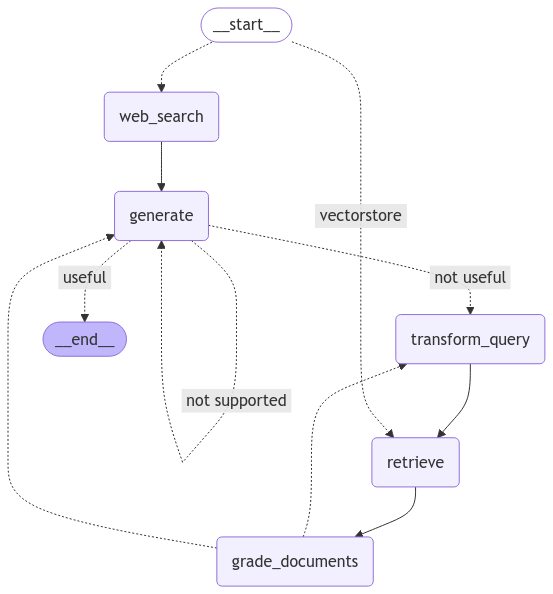

In [22]:
from IPython.display import Image, display

display(Image(
    app.get_graph(xray=True).draw_mermaid_png()
))

# Use Graph

In [25]:
from pprint import pprint

# Run
inputs = {
    'question': 'What player at the Bears expected to draft first in the 2024 NFL draft?',
}

for output in app.stream(inputs):
    for key, val in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(val, indent=2, width=80, depth=None)
    pprint('\n---\n')

# Final generation
pprint(val['generation'])

--- ROUTE QUESTION ---
--- ROUTE QUESTION TO WEB SEARCH ---
--- WEB SEARCH ---
"Node 'web_search':"
{ 'documents': Document(metadata={}, page_content="The Bears on Thursday, as expected, selected USC quarterback Caleb Williams with the No. 1 pick in the 2024 NFL Draft. Williams was widely considered the top prospect in a draft class loaded with talented quarterbacks.\nHere is how Ryan Poles and Matt Eberflus did with their selections for the Chicago Bears 2024 NFL Draft: Round 1 • Pick 1 (1) • QB Caleb Williams USC. Round 1 • Pick 9 (9) • WR Rome Odunze\nThe Chicago Bears selected five players during the 2024 NFL draft, which included landing two of the draft's best players in quarterback Caleb Williams and wide receiver Rome Odunze at first and\nThe Chicago Bears made waves during the first round of the 2024 NFL draft, where they added two blue chip players to the roster with their top-10 selections -- quarterback Caleb Williams (No. 1) and wide receiver Rome Odunze (No. 9). The First

In [26]:
# Run
inputs = {'question': 'What are the types of agent memory?'}

for output in app.stream(inputs):
    for key,val in output.items():
        # Node
        pprint(f"Node '{key}':")
        pprint(val, indent=2, width=80, depth=None)
    pprint('\n---\n')

# Final generation
pprint(val['generation'])

--- ROUTE QUESTION ---
--- ROUTE QUESTION TO RAG ---
--- RETRIEVE ---
"Node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory and exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and DQN for